### Read in Libraries

In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
from datetime import datetime
from dateutil import tz
import pytz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout


### Read in the data

In [133]:
df = pd.read_csv('../data/final_dfs/combined_final.csv', index_col='date')

In [134]:
df.head()

,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
date,,,,,,,,
2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [135]:
df.reset_index(inplace=True)

In [136]:
df['date'] = pd.to_datetime(df['date'])


In [137]:
train_dates = pd.to_datetime(df['date'])

In [138]:
df.isnull().sum()

date       0
Biomass    0
Coal       0
Hydro      0
Nuclear    0
Other      0
Solar      0
Wind       0
NGas       0
dtype: int64

In [139]:
df['total'] = df.sum(axis=1)

In [140]:
df

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas,total
0,2011-01-01,1240.848016,304483.898100,670.712237,90516.910230,357.449324,70.651290,123213.388200,248086.363990,7.686402e+05
1,2011-01-02,1478.590690,320703.672600,667.009668,90462.214940,372.626928,10.255158,62531.398440,268971.649980,7.451974e+05
2,2011-01-03,1483.246127,296436.223700,741.426017,90472.370750,401.536782,15.155827,89515.573520,222285.009850,7.013505e+05
3,2011-01-04,1411.010006,322214.637700,683.281626,90312.687080,478.415477,5.278214,59542.485700,271747.936850,7.463957e+05
4,2011-01-05,1348.331266,308136.080100,623.145421,90280.191600,440.383112,22.997359,128920.842500,358001.800050,8.877738e+05
...,...,...,...,...,...,...,...,...,...,...
3648,2020-12-27,635.255371,184407.678785,500.494667,122762.954790,13.731479,29820.239198,321323.147861,194637.587100,8.541011e+05
3649,2020-12-28,591.302614,193621.421107,636.269588,122720.408975,-13.652177,19924.960198,350947.810220,216475.798107,9.049043e+05
3650,2020-12-29,667.202987,144900.104532,643.995831,122664.769337,-26.962775,11594.382815,443182.060206,167954.504264,8.915801e+05
3651,2020-12-30,704.598125,158272.638521,655.564849,122629.625647,19.636788,3539.284392,434953.837358,227983.660971,9.487588e+05


### Let's select the columns we want to model as a separate dataframe

In [116]:
cols = list(df)[2:9]

In [117]:
df_for_train = df[cols].astype(float)

In [118]:
df_for_train

,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,304483.898100,670.712237,90516.910230,357.449324,70.651290,123213.388200,248086.363990
1,320703.672600,667.009668,90462.214940,372.626928,10.255158,62531.398440,268971.649980
2,296436.223700,741.426017,90472.370750,401.536782,15.155827,89515.573520,222285.009850
3,322214.637700,683.281626,90312.687080,478.415477,5.278214,59542.485700,271747.936850
4,308136.080100,623.145421,90280.191600,440.383112,22.997359,128920.842500,358001.800050
...,...,...,...,...,...,...,...
3648,184407.678785,500.494667,122762.954790,13.731479,29820.239198,321323.147861,194637.587100
3649,193621.421107,636.269588,122720.408975,-13.652177,19924.960198,350947.810220,216475.798107
3650,144900.104532,643.995831,122664.769337,-26.962775,11594.382815,443182.060206,167954.504264
3651,158272.638521,655.564849,122629.625647,19.636788,3539.284392,434953.837358,227983.660971


### Because each generation source has relatively different usages, let's apply a scaler to our dataframe

In [119]:
sc = StandardScaler()
sc = sc.fit(df_for_train)
df_scale = sc.transform(df_for_train)

In [120]:
df_scale

array([[ 0.25336095, -0.74434616, -1.07961399, ..., -0.67640677,
        -0.21044873, -1.20060769],
       [ 0.45839143, -0.74690399, -1.08274326, ..., -0.68377723,
        -0.91128669, -1.05487503],
       [ 0.15163214, -0.69549531, -1.08216221, ..., -0.68317918,
        -0.59963682, -1.38064352],
       ...,
       [-1.76390143, -0.76280252,  0.75965482, ...,  0.72989568,
         3.48498367, -1.75974911],
       [-1.59486227, -0.75481035,  0.75764415, ..., -0.25311096,
         3.38995299, -1.34087966],
       [-1.49678959, -0.84266111,  0.75382754, ..., -0.28810127,
         2.41803163,  0.13744187]])

### Now let's reshape our input data such that we define our training data in the past with the associated timestep in the future that we want to predict

In [121]:
trainX = []
trainY = []

n_future = 1  # How far ahead we want to predict
n_past = 14   # How many days in the past we want to use for predicting

for i in range(n_past, len(df_scale) - n_future +1):
    trainX.append(df_scale[i - n_past:i, 0:df_for_train.shape[1]])
    trainY.append(df_scale[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3639, 14, 7).
trainY shape == (3639, 1).


## LSTM Time Series Models

In [122]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 64)            18432     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [123]:
history= model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
205/205 [==============================] - 6s 16ms/step - loss: 0.4338 - val_loss: 0.1364
Epoch 2/10
205/205 [==============================] - 2s 10ms/step - loss: 0.2132 - val_loss: 0.1221
Epoch 3/10
205/205 [==============================] - 2s 10ms/step - loss: 0.1618 - val_loss: 0.2411
Epoch 4/10
205/205 [==============================] - 2s 10ms/step - loss: 0.1516 - val_loss: 0.1760
Epoch 5/10
205/205 [==============================] - 3s 13ms/step - loss: 0.1300 - val_loss: 0.1003
Epoch 6/10
205/205 [==============================] - 2s 10ms/step - loss: 0.1276 - val_loss: 0.1091
Epoch 7/10
205/205 [==============================] - 2s 12ms/step - loss: 0.1106 - val_loss: 0.1172
Epoch 8/10
205/205 [==============================] - 3s 15ms/step - loss: 0.1291 - val_loss: 0.1249
Epoch 9/10
205/205 [==============================] - 3s 13ms/step - loss: 0.1103 - val_loss: 0.1093
Epoch 10/10
205/205 [==============================] - 2s 12ms/step - loss: 0.1119 - val_lo

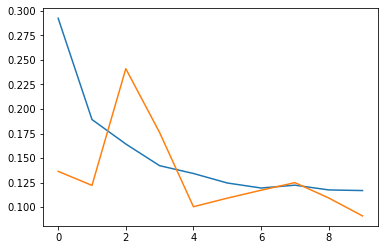

In [124]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [125]:
n_forecast = 30
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_forecast, freq='1d', tz=None).tolist()

In [126]:
forecast = model.predict(trainX[-n_forecast:]) # forecast

In [127]:
forecast_copies = np.repeat(forecast, df_for_train.shape[1], axis=-1)
y_pred_future = sc.inverse_transform(forecast_copies)[:,0]  # Take

In [128]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [129]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Coal':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [130]:
df_forecast

,Date,Coal
0,2020-12-31,225381.484375
1,2021-01-01,237003.453125
2,2021-01-02,233727.140625
3,2021-01-03,225866.843750
4,2021-01-04,231461.734375
5,2021-01-05,193524.562500
6,2021-01-06,204136.312500
7,2021-01-07,189503.421875
8,2021-01-08,185716.515625
9,2021-01-09,200037.140625


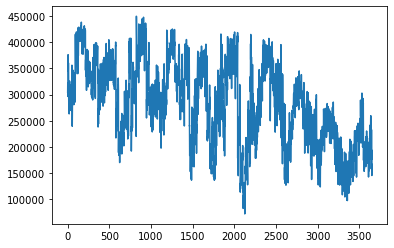

In [70]:
plt.plot(df['Coal'])

/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Coal'>

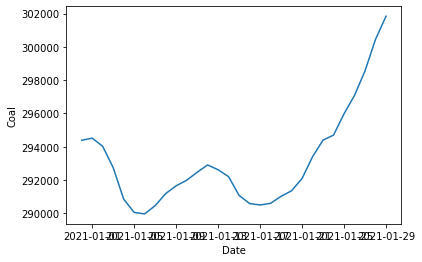

In [91]:
original = df[['date', 'Coal']]
sns.lineplot(df_forecast['Date'], df_forecast['Coal'])

In [89]:
original

,date,Coal
0,2011-01-01,304483.898100
1,2011-01-02,320703.672600
2,2011-01-03,296436.223700
3,2011-01-04,322214.637700
4,2011-01-05,308136.080100
...,...,...
3648,2020-12-27,184407.678785
3649,2020-12-28,193621.421107
3650,2020-12-29,144900.104532
3651,2020-12-30,158272.638521


In [90]:
df_forecast

,Date,Coal
0,2020-12-31,294383.31250
1,2021-01-01,294512.84375
2,2021-01-02,294025.90625
3,2021-01-03,292743.46875
4,2021-01-04,290850.75000
5,2021-01-05,290047.71875
6,2021-01-06,289957.62500
7,2021-01-07,290454.71875
8,2021-01-08,291174.40625
9,2021-01-09,291646.50000


In [85]:

sns.lineplot(original['date'], original['Coal'])
sns.lineplot(df_forecast['Date'], df_forecast['Coal'])

/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='Coal'>

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

## Dickey-Fuller Tests on each Source

### Total

In [35]:
interpret_dftest(adfuller(df['total']))

Test Statistic    -3.656148
p-value            0.004774
Lag Used          29.000000
dtype: float64

In [81]:
interpret_dftest(adfuller(df['total'].diff(1).dropna()))

Test Statistic   -1.692813e+01
p-value           9.823692e-30
Lag Used          2.800000e+01
dtype: float64

In [82]:
df['first_diff_total'] = df['total'].diff(1)

### Biomass

In [24]:
interpret_dftest(adfuller(df['Biomass']))

Test Statistic   -7.435146e+00
p-value           6.211646e-11
Lag Used          2.400000e+01
dtype: float64

### Coal

In [25]:
interpret_dftest(adfuller(df['Coal']))

Test Statistic    -2.877402
p-value            0.048040
Lag Used          29.000000
dtype: float64

In [83]:
interpret_dftest(adfuller(df['Coal'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [85]:
df['first_diff_coal'] = df['Coal'].diff(1)

### Gas

In [26]:
interpret_dftest(adfuller(df['NGas']))

Test Statistic    -4.165856
p-value            0.000752
Lag Used          24.000000
dtype: float64

In [79]:
interpret_dftest(adfuller(df['NGas'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [87]:
df['first_diff_ngas'] = df['NGas'].diff(1)

### Hydro

In [28]:
interpret_dftest(adfuller(df['Hydro']))

Test Statistic    -4.377611
p-value            0.000325
Lag Used          30.000000
dtype: float64

### Nuclear

In [14]:
interpret_dftest(adfuller(df['Nuclear']))

Test Statistic   -2.949252
p-value           0.039913
Lag Used          3.000000
dtype: float64

In [88]:
interpret_dftest(adfuller(df['Nuclear'].diff(1).dropna()))

Test Statistic   -1.480475e+01
p-value           2.073387e-27
Lag Used          3.000000e+01
dtype: float64

In [89]:
df['first_diff_nuclear'] = df['Nuclear'].diff(1)

### Other

In [29]:
interpret_dftest(adfuller(df['Other']))

Test Statistic    -4.578738
p-value            0.000141
Lag Used          30.000000
dtype: float64

### Wind

In [30]:
interpret_dftest(adfuller(df['Wind']))

Test Statistic    -2.681855
p-value            0.077231
Lag Used          28.000000
dtype: float64

In [31]:
# Differenced 
interpret_dftest(adfuller(df['Wind'].diff(1).dropna()))

Test Statistic   -1.804267e+01
p-value           2.654696e-30
Lag Used          3.000000e+01
dtype: float64

#### Because we see a much lower p-value with the differenced data, let's save this column to our dataframe to use in our model

In [37]:
df['first_diff_wind'] = df['Wind'].diff(1)

### Solar

In [32]:
interpret_dftest(adfuller(df['Solar']))

Test Statistic    -1.083391
p-value            0.721650
Lag Used          28.000000
dtype: float64

In [75]:
interpret_dftest(adfuller(df['Solar'].diff(1).dropna()))

Test Statistic   -1.471495e+01
p-value           2.809432e-27
Lag Used          3.000000e+01
dtype: float64

In [76]:
df['first_diff_solar'] = df['Solar'].diff(1)

### Plot ACF & PACF

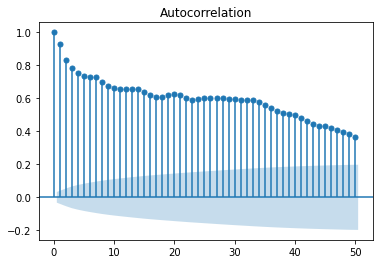

In [33]:
# plot the total electricity acf
plot_acf(df['total'], lags = 50);

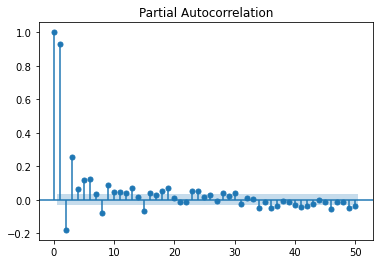

In [36]:
# plot the total electricity pacf
plot_pacf(df['total'], lags = 50);